# [LAB-10] 11.이원분산분석 (2) (Two way ANOVA)

두 개의 명목형 요인이 연속형 종속변수의 평균에 어떤 영향을 미치는지, 그리고 두 요인간 상호작용 효과가 존재하는지를 검정하는 통계 방법


분석을 수행하기 전에는 일원분산분석과 동일하게 정규성과 등분산성 등의 기본 가정이 충족되어야한다

이원 분산분석의 주요 목적은 상호작용 효과의 존재 여부를 파악하는 데 있으므로 수준이 개 이상인 요인의 주효과가 유의할 떄 해당 요인에 대해서만 사후검정을 수행한다





### #01.준비작업
#### [1] 패키지 참조

In [1]:
from hossam import load_data
from pandas import melt, DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
from math import sqrt


# 가정 확인을 위한 라이브러리
from scipy.stats import t, normaltest, bartlett, levene


# 분산분석을 위한 라이브러리
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from pingouin import anova
from pingouin import welch_anova


# 사후검정을 위한 라이브러리
from pingouin import pairwise_tukey, pairwise_tests, pairwise_gameshowell

#### [2] 그래프 초기화

In [2]:
#한글을 지원하는 폰트 파일의 경로
font_path ='C:\\Data_Analysis_Basic\\[LAB-06] 데이터 시각화 개요\\NotoSansKR-Regular.ttf'
#폰트의 그룹을 시스템에 등록
fm.fontManager.addfont(font_path)
#폰트의 속성을 읽어옴
font_prop = fm.FontProperties(fname=font_path)
#읽어온 속성에서 폰트의 이름만 추출
font_name = font_prop.get_name()

#이미지의 선명도를 결정 (1인치 당 픽셀의 수)
my_dpi = 120 
#시스템에 등록된 글꼴 이름  (상단에서 확인한 폰트 이름으로 넣기)
my_font_name = 'Noto Sans KR'
#그림 스타일 지정
my_theme = 'dark'
#seaborn 스타일 (화풍 설정하기)
sb.set_theme(style=my_theme)
#그래프에 한글 폰트 적용
plt.rcParams['font.family']=my_font_name
#기본 폰트 크기
plt.rcParams['font.size'] =16
#그래프에 마이너스 꺠짐 방지 (한글환경에서 필수)
plt.rcParams['axes.unicode_minus']=False

### #02. 예제1 -측정자에 따른 태아의 머리 둘레 측정 비교
다음의 데이터는 3명의 태아를 대상으로 3명의 관측자가 측정한 자료이다
측정자에따라 태아의 머리 둘레가 다르게 나타나는지 확인하라


#### [1] 데이터 가져오기

In [3]:
origin = load_data('head_size')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print("\n===== 타입확인 =====")

print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/lab10_/head_size.xlsx
[desc] 3명의 태아를 대상으로 3명의 관측자가 측정한 태아의 머리 둘레 자료 (출처: 방송통신대학교 통계학 개론)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기: (60, 4)
열 개수: 4
행 개수: 60

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   측정자번호   60 non-null     int64  
 1   1번태아    60 non-null     float64
 2   2번태아    60 non-null     float64
 3   3번태아    60 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 2.0 KB
None


,측정자번호,1번태아,2번태아,3번태아
0,1,14.9,19.7,13.0
1,1,14.4,20.7,13.5
2,1,14.4,19.9,13.2
3,1,15.1,20.2,12.8
4,1,15.4,19.4,13.8


#### [2] 데이터 전처리
이원 분산분석을 수행하기에 적합한 형태는 melt 처리된 구조

In [4]:
df = melt(origin, id_vars = '측정자번호',value_vars =['1번태아','2번태아','3번태아'],var_name = '태아번호',value_name = '머리둘레')

df.head()

,측정자번호,태아번호,머리둘레
0,1,1번태아,14.9
1,1,1번태아,14.4
2,1,1번태아,14.4
3,1,1번태아,15.1
4,1,1번태아,15.4


#### [3] 데이터 분포 시각화
1) 측정자별 태아에 따른 머리 둘레 비교


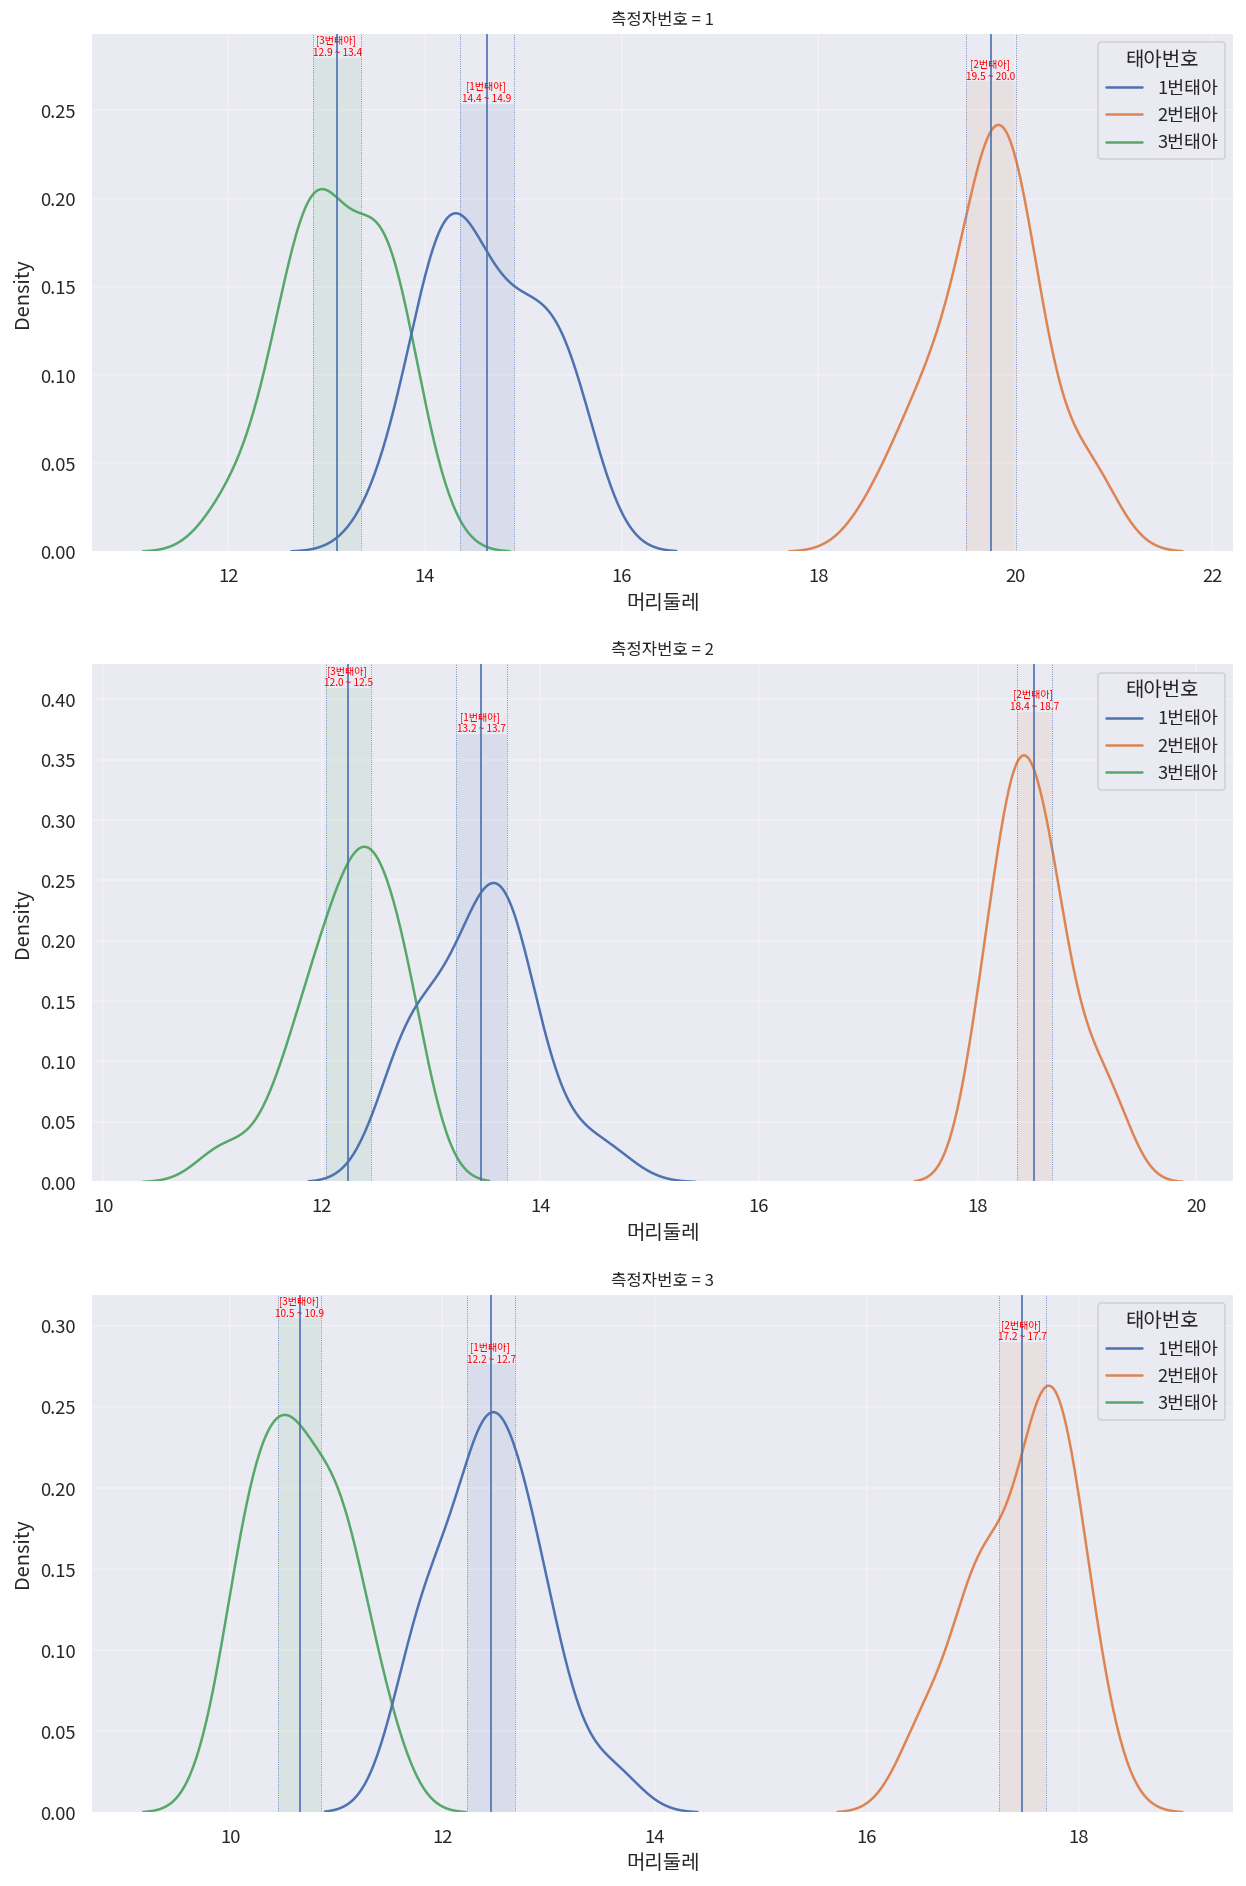

In [6]:
field = '머리둘레'
group_field = '측정자번호'
hue_field = '태아번호'

# 시각화 할 필드만 원본 데이터에서 추출
data = df[[field, group_field, hue_field]]

group_values = data[group_field].unique()
group_count = len(group_values)
hue_values = data[hue_field].unique()

# 1) 그래프 초기화
rows = group_count                  # 그래프 행 수
cols = 1 # 그래프 열 수
width_px  = 1280 * cols             # 그래프 가로 크기
height_px = 640* rows              # 그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

# ax 객체가 행,열 수에 따라서 리스트가 된다.
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기
for i, v in enumerate(group_values):
    temp = data[data[group_field] == v]
    sb.kdeplot(data=temp, x=field, hue=hue_field, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title('{0} = {1}'.format(group_field, v), fontsize=10, pad=5)

    for h in hue_values:
        temp_sub = temp[temp[hue_field] == h]
        
        # 신뢰구간
        max = temp_sub[field].max()                         # 최대값
        clevel = 0.95 # 신뢰수준
        dof = len(temp_sub[field]) -1 # 자유도
        sp_mean = temp_sub[field].mean()                    # 표본평균
        sp_std = temp_sub[field].std(ddof=1)                # 표본표준편차
        sp_std_error = sp_std / sqrt(len(temp_sub[field]))  # 표본표준오차
        
        cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)
        
        ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
        ax[i].axvline(cmax, linestyle=':', linewidth=0.5)
        
        # 평균 표시
        ymin, ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle='-', linewidth=1)
        
        # 텍스트 그리기
        ax[i].text(x=(cmax-cmin)/2+cmin,
                y=ymax,
                s="[%s] \n%0.1f ~ %0.1f" % (h, cmin, cmax),
                horizontalalignment="center",
                verticalalignment="bottom",
                fontdict={"size": 6, "color": "red"})

# 4) 출력
plt.tight_layout()      
plt.show()              
# 여백 제거
# 그래프 화면 출력
plt.close()             
# 그래프 작업 종료

2) 태아별 측정자에 따른 머리 둘레 비교
  

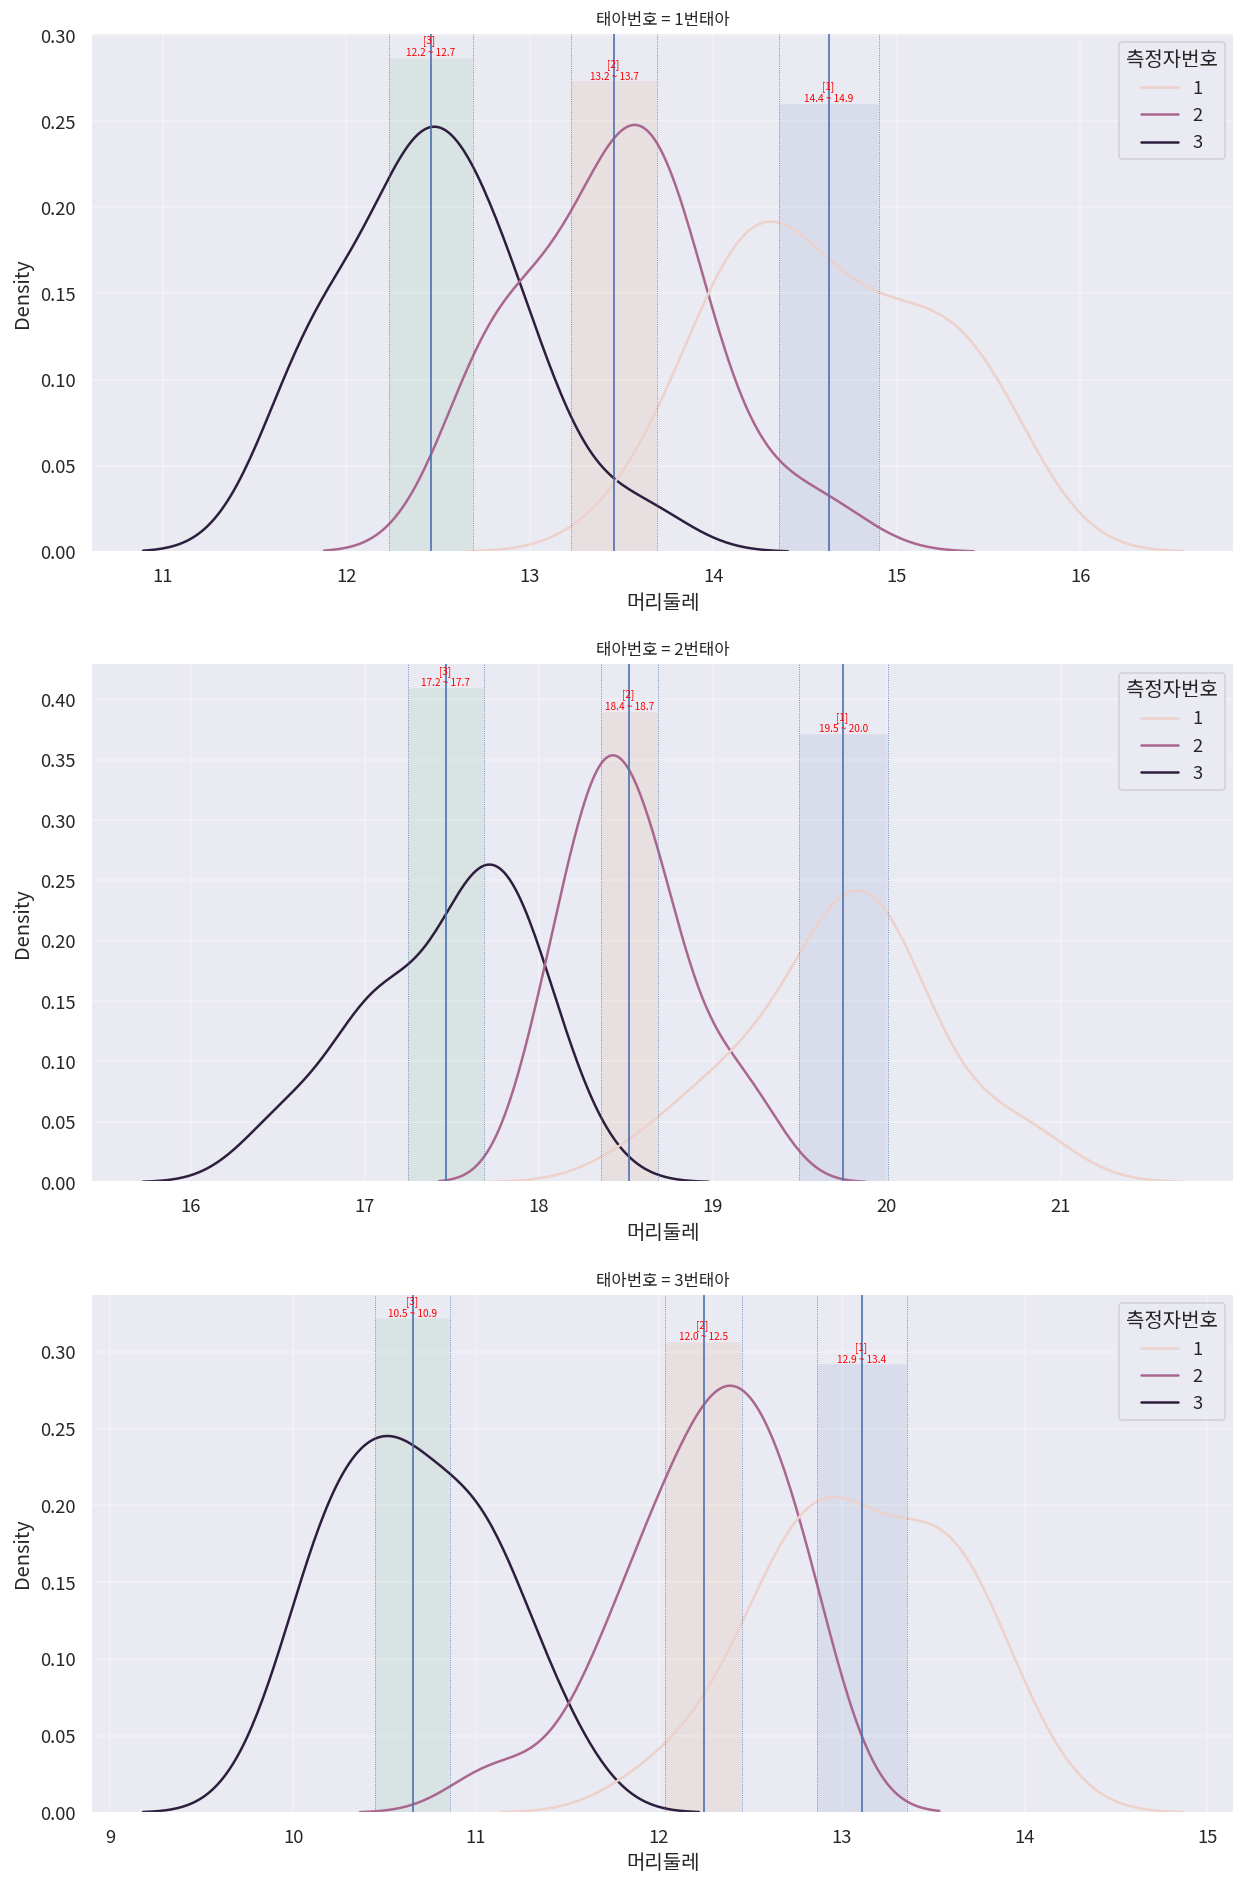

In [7]:
field = '머리둘레'
group_field = '태아번호'
hue_field = '측정자번호'

# 시각화 할 필드만 원본 데이터에서 추출
data = df[[field, group_field, hue_field]]

group_values = data[group_field].unique()
group_count = len(group_values)
hue_values = data[hue_field].unique()

# 1) 그래프 초기화
rows = group_count                  # 그래프 행 수
cols = 1 # 그래프 열 수
width_px  = 1280 * cols             # 그래프 가로 크기
height_px = 640* rows              # 그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

# ax 객체가 행,열 수에 따라서 리스트가 된다.
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기
for i, v in enumerate(group_values):
    temp = data[data[group_field] == v]
    sb.kdeplot(data=temp, x=field, hue=hue_field, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title('{0} = {1}'.format(group_field, v), fontsize=10, pad=5)

    for h in hue_values:
        temp_sub = temp[temp[hue_field] == h]
        
        # 신뢰구간
        max = temp_sub[field].max()                         # 최대값
        clevel = 0.95 # 신뢰수준
        dof = len(temp_sub[field]) -1 # 자유도
        sp_mean = temp_sub[field].mean()                    # 표본평균
        sp_std = temp_sub[field].std(ddof=1)                # 표본표준편차
        sp_std_error = sp_std / sqrt(len(temp_sub[field]))  # 표본표준오차
        
        cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)
        
        ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
        ax[i].axvline(cmax, linestyle=':', linewidth=0.5)
        
        # 평균 표시
        ymin, ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle='-', linewidth=1)
        
        # 텍스트 그리기
        ax[i].text(x=(cmax-cmin)/2+cmin,
                y=ymax,
                s="[%s] \n%0.1f ~ %0.1f" % (h, cmin, cmax),
                horizontalalignment="center",
                verticalalignment="bottom",
                fontdict={"size": 6, "color": "red"})

# 4) 출력
plt.tight_layout()      
plt.show()              
# 여백 제거
# 그래프 화면 출력
plt.close()             
# 그래프 작업 종료

#### [4] 가설검정의 가정 확인

In [8]:
data = df.copy()
xname = ['측정자번호', '태아번호']
yname = '머리둘레'

u1 = data[xname[0]].unique()
u2 = data[xname[1]].unique()
equal_var_fields = []
normal_dist = True
report = []

for i in u1:
    for j in u2:
        filtered_data = data[(data[xname[0]] == i) & (data[xname[1]] == j)][yname]
        equal_var_fields.append(filtered_data)
        s, p = normaltest(filtered_data)

        normalize = p > 0.05
        report.append({
            "field": "{0}, {1}".format(i, j),
            "statistic": s,
            "p-value": p,
            "result": normalize
        })
        normal_dist = normal_dist and normalize

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*equal_var_fields)
else:
    n = "Levene"
    s, p = levene(*equal_var_fields)

equal_var = p > 0.05

report.append({
    "field": n,
    "statistic": s,
    "p-value": p,
    "result": p > 0.05
})

report_df = DataFrame(report).set_index('field')
report_df

,statistic,p-value,result
field,,,
"1, 1번태아",1.885153,0.389623,True
"1, 2번태아",0.290183,0.864943,True
"1, 3번태아",0.408716,0.815171,True
"2, 1번태아",0.454973,0.796533,True
"2, 2번태아",1.442948,0.486035,True
"2, 3번태아",3.862339,0.144979,True
"3, 1번태아",0.666927,0.716438,True
"3, 2번태아",1.463170,0.481146,True
"3, 3번태아",0.846989,0.654755,True


#### [5] 분산분석 수행

In [12]:
xname = ['측정자번호' , '태아번호']
yname = '머리둘레'
data = df[xname + [yname]]

if equal_var:
    pg_anova = anova(data=data, dv=yname, between=xname)
else:
    pg_anova = welch_anova(data=data, dv=yname, between=xname)
display(pg_anova)
for idx in pg_anova.index:
    row = pg_anova.iloc[idx]
    source = row['Source']
    p_val = row['p-unc']

    if p_val <= 0.05:
      print(f"→ {source} 효과는 유의함. (대립가설 채택: p ≤ 0.05)")

    else:
      print(f"→ {source} 효과는 유의하지 않음. (귀무가설 채택: p > 0.05)")

,Source,SS,DF,MS,F,p-unc,np2
0,측정자번호,159.320778,2,79.660389,336.822068,4.904107e-60,0.797548
1,태아번호,1422.825444,2,711.412722,3008.013241,5.616407e-134,0.972362
2,측정자번호 * 태아번호,2.201222,4,0.550306,2.326816,5.827850e-02,0.051619
3,Residual,40.442500,171,0.236506,NaN,NaN,NaN


→ 측정자번호 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ 태아번호 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ 측정자번호 * 태아번호 효과는 유의하지 않음. (귀무가설 채택: p > 0.05)
→ Residual 효과는 유의하지 않음. (귀무가설 채택: p > 0.05)


#### [6] 사후검정

In [14]:


# 데이터 준비
xname = ['측정자번호', '태아번호']
yname = '머리둘레'
data = df[xname + [yname]]

# 1) 각 요인의 수준(집단) 개수 파악
levels = {}   
for factor in xname:                     
    level_count = data[factor].nunique() # 요인의 수준 수 계산
    levels[factor] = level_count         # 딕셔너리에 저장 ({'water': 2, 'sun': 3})

# 2) ANOVA 결과에서 p-value 추출
pvals = {}   
for index, row in pg_anova.iterrows():     
    source_name = row['Source']            
    p_value = row['p-unc']                 
    pvals[source_name] = p_value         # 딕셔너리에 저장 ({'water': 1.3e-20...})

# 3) 주효과에 대한 사후검정 판단 자동화
for factor in xname:
    print(f"\n[{factor}]")
    
    # 수준이 2개 이하이면 사후검정 불필요 (t-test와 동일하거나 평균 차이만 보면 됨)
    # 오타 수정: /= 2 -> <= 2
    if levels[factor] <= 2:
        print(f"- {levels[factor]}수준 요인이므로 사후검정이 필요 없습니다.")
        continue

    # 해당 요인의 p-value 가져오기
    p_val = pvals.get(factor, None)
    
    if p_val is None:
        print("- ANOVA 결과에서 해당 요인을 찾을 수 없습니다.")
        continue
    
    # 유의하지 않으면 사후검정 생략
    if p_val > 0.05:
        print(f"- 주효과 유의하지 않음 (p={p_val:.3g}) → 사후검정 수행 안 함")
        continue
    
    # 유의한 경우 사후검정 수행
    print(f"- 주효과 유의 (p={p_val:.3g}) → 사후검정 수행")
    
    # 등분산 여부(equal_var)는 앞선 코드에서 정의되었다고 가정
    if equal_var:
        print("  · Tukey HSD 사용 (등분산 충족)")
        hoc_df = pairwise_tukey(data=data, dv=yname, between=factor)
    else:
        print("  · Games–Howell 사용 (등분산 불충족)")
        hoc_df = pairwise_gameshowell(data=data, dv=yname, between=factor)
    
    display(hoc_df)

# 4) 상호작용 효과 판단 자동화
interaction_names = [src for src in pvals.keys() if '*' in src]

for inter in interaction_names:
    p_val = pvals[inter]
    print(f"\n[{inter}] 상호작용 효과")
    
    # 오타 수정: /= 0.05 -> < 0.05 (유의확률 기준)
    if p_val < 0.05:
        print(f"- 상호작용 유의 (p={p_val:.3g}) → 단순주효과 분석 필요")
    else:
        print(f"- 상호작용 유의하지 않음 (p={p_val:.3g}) → 단순주효과 분석 필요 없음")


[측정자번호]
- 주효과 유의 (p=4.9e-60) → 사후검정 수행
  · Tukey HSD 사용 (등분산 충족)


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,1,2,15.830000,14.741667,1.088333,0.525341,2.071671,0.098702,0.380087
1,1,3,15.830000,13.526667,2.303333,0.525341,4.384456,0.000059,0.781644
2,2,3,14.741667,13.526667,1.215000,0.525341,2.312785,0.056613,0.422358



[태아번호]
- 주효과 유의 (p=5.62e-134) → 사후검정 수행
  · Tukey HSD 사용 (등분산 충족)


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,1번태아,2번태아,13.516667,18.578333,-5.061667,0.195025,-25.953939,0.000000e+00,-4.841750
1,1번태아,3번태아,13.516667,12.003333,1.513333,0.195025,7.759689,1.915246e-12,1.393082
2,2번태아,3번태아,18.578333,12.003333,6.575000,0.195025,33.713629,0.000000e+00,6.016793



[측정자번호 * 태아번호] 상호작용 효과
- 상호작용 유의하지 않음 (p=0.0583) → 단순주효과 분석 필요 없음


### #03.인사이트
#### 1.분석목적

본 분석은 태아의 머리둘레에 대해 관측자와 태아 개체가 어떤 영향을 미치는지를 평가하기 위해 이원분산분석을 수행하였다



#### 2.분산분석 주요 결과

2-1 요인별 유의성 판단 (유의수준 a=0.o5 기준)

- 측정자번호: p ≤ 0.05 → 유의함(대립가설 채택)
- 태아번호: p ≤ 0.05 → 유의함(대립가설 채택)
- 측정자번호 × 태아번호: p > 0.05 → 유의하지 않음(귀무가설 채택)

요약 : 측정자에 따라 측정값이 달라지는 경향이 있으며, 태아간 실제 머리 둘레 차이는 매우 크다
그러나 측정자와 태아의 결합 효과는 확인되지 않는다

#### 3. 기술통계 및 집단별 평균 비교

● 측정자번호 수준별 평균

측정자 1: 15.83

측정자 2: 14.74

측정자 3: 13.53
→ 관측자마다 평균 측정값이 일관되게 다름.

● 태아번호 수준별 평균

1번 태아: 13.52

2번 태아: 14.58

3번 태아: 12.00
→ 태아 간 본질적인 머리둘레 차이가 매우 큼.

● 상호작용 패턴 해석

모든 관측자가 태아 1·2·3을 측정할 때 **비슷한 순서(2번 > 1번 > 3번)**를 유지하며,
특정 태아에서만 관측자 차이가 갑자기 커지는 양상은 없음.

요약 해석

평균 패턴이 평행하게 나타나 상호작용 효과가 약함을 시사한다.

#### 4. 사후검정(Post-hoc) 결과

(유의수준 α = 0.05 기준 — ‘유의함 / 유의하지 않음’만 표시)

📌 측정자번호 (주효과 유의 → 사후검정 실시)

1 vs 3 → 유의함 (p < 0.05)

1 vs 2 → 유의하지 않음 (p > 0.05)

2 vs 3 → 유의함 (p < 0.05)

→ 측정자 1과 3만 통계적으로 차이가 있음.

📌 태아번호 (주효과 유의 → 사후검정 실시)

2번 > 1번 태아 → 유의함 (p < 0.05)

1번 vs 3번 태아 → 유의함 (p < 0.05)

2번 vs 3번 태아 → 유의함 (p < 0.05)

→ 모든 태아 간 차이가 명확함.

📌 상호작용

p = 0.05 > 0.05 → 유의하지 않음
→ 단순효과 분석 불필요

📝 요약 해석

측정자 간 비교에서는 1·3만 유의함,

태아 간 비교에서는 모든 쌍이 유의함.


#### 5. 최종 결론 요약
- 측정자마다 측정값의 편차가 존재하며 주효과가 유의함
- 태아 자체의 머리둘레 차이는 매우 크고 모든 쌍에서 뚜렷하게 유의함
- 상호작용 효과는 유의하지 않아 특정 관측자가 특정 태아만 과대 , 과소 측정하는 패턴은 없음
- 분산분석과 사후검정 모두 태아 간 개체 차이가 변동의 핵심 요인임을 보여움

최종 한 문장 결론
: 태아의 머리둘레는 관측자 효과와 태아 개체 차이에 의해 유의하게 달라지지만, 두 요인의 상호 작용 효과는 존재하지 않는다
